Hier werden die Ergebnisse eingelesen und ausgewertet

In [1]:
#Import der notwendigen Bibliotheken, Installation mit pip bereits erfolgt

import yfinance as yf
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np
import csv
from scipy.optimize import minimize
import math
import random
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import linkage, dendrogram
import riskfolio as rp
from sklearn.covariance import LedoitWolf
from scipy.spatial.distance import squareform
from riskfolio import HCPortfolio as hc

In [2]:
def gesamt_return(returns):

    total = np.cumprod(1 + returns)
    
    return total

In [3]:
def portfolio_return (returns):
    
    pf_return = returns.mean()
    
    return pf_return

In [4]:
def portfolio_variance (returns):
    
    pf_var = np.var(returns)
    
    return pf_var

In [5]:
def portfolio_volatility (returns):
    variance = portfolio_variance(returns)
    volatility = np.sqrt(variance)
    
    return volatility

In [6]:
def sharpe_ratio (returns):
    pf_return = portfolio_return (returns)
    volatility = portfolio_volatility (returns)
    zins_risikofrei = 0
    
    sharpe_ratio = (pf_return - zins_risikofrei) / volatility
    
    return sharpe_ratio

In [7]:
def sharpe_ratio_one (gewichte, returns):
    pf_return = portfolio_return (gewichte, returns)
    volatility = portfolio_volatility (gewichte, returns)
    zins_risikofrei = 0.01
    
    sharpe_ratio = (pf_return - zins_risikofrei) / volatility
    
    return sharpe_ratio

In [8]:
def sharpe_ratio_two (gewichte, returns):
    pf_return = portfolio_return (gewichte, returns)
    volatility = portfolio_volatility (gewichte, returns)
    zins_risikofrei = 0.02
    
    sharpe_ratio = (pf_return - zins_risikofrei) / volatility
    
    return sharpe_ratio

In [9]:
def sortino_ratio (returns): 
    
    zins_risikofrei = 0
        
    temp = (np.minimum(0, returns - zins_risikofrei))**2
    temp = np.mean(temp)
    
    downside_dev = np.sqrt(temp)
    
    pf_return = portfolio_return (returns)
    
    sortino_ratio = (pf_return - zins_risikofrei) / downside_dev
    
    return sortino_ratio

In [10]:
def sortino_ratio_one (gewichte, returns):    
    daily_returns = []
    zins_risikofrei = 0.01
    
    for index, zeile in returns.iterrows():
        daily_returns.append(np.dot(gewichte, zeile))
    
    daily_returns = np.array(daily_returns)
        
    temp = np.minimum(0, daily_returns - zins_risikofrei)**2
    temp = np.mean(temp)
    
    downside_dev = np.sqrt(temp)
    
    pf_return = portfolio_return (gewichte, returns)
    
    sortino_ratio = (pf_return - zins_risikofrei) / downside_dev
    
    return sortino_ratio

In [11]:
def sortino_ratio_two (gewichte, returns):    
    daily_returns = []
    zins_risikofrei = 0.02
    
    for index, zeile in returns.iterrows():
        daily_returns.append(np.dot(gewichte, zeile))
    
    daily_returns = np.array(daily_returns)
        
    temp = np.minimum(0, daily_returns - zins_risikofrei)**2
    temp = np.mean(temp)
    
    downside_dev = np.sqrt(temp)
    
    pf_return = portfolio_return (gewichte, returns)
    
    sortino_ratio = (pf_return - zins_risikofrei) / downside_dev
    
    return sortino_ratio

In [12]:
def maximum_drawdown (returns):
    
    returns_kumuliert = (1 + returns).cumprod()
    hochpunkte = returns_kumuliert.cummax()
    
    drawdowns = (returns_kumuliert - hochpunkte) / hochpunkte
    max_drawdown = drawdowns.min()
    
    #print(drawdowns)
    return max_drawdown

In [13]:
def calmar_ratio (returns):
    total_return = (1 + returns).prod() - 1
    annualized_return = (1 + total_return) ** (252 / len(returns)) - 1
    max_drawdown = maximum_drawdown(returns)
    
    calmar_ratio = annualized_return / (-max_drawdown)
    
    return calmar_ratio

In [14]:
def calmar_ratio_total (returns):
    total_return = (1 + returns).prod() - 1
    
    max_drawdown = maximum_drawdown(returns)
    calmar_ratio_gesamt = total_return / (-max_drawdown)
    
    return calmar_ratio_gesamt

In [15]:
def value_at_risk_func(returns):
    sorted_daily_returns = returns.sort_values(ascending = True)
    value_at_risk = np.percentile(sorted_daily_returns, 100*0.05)
    return value_at_risk

In [16]:
#https://github.com/malctaylor15/VaR-and-Expected-Shortfall-Python/blob/master/Expected%20Shortfall%20and%20Value%20at%20Risk.ipynb

def expected_shortfall(returns):
    sorted_daily_returns = returns.sort_values(ascending = True)
    value_at_risk = value_at_risk_func(returns)
    
    expected_shortfall = sorted_daily_returns[sorted_daily_returns <= value_at_risk].mean()
    
    return expected_shortfall

## Auswertung S&P 500 Voll

In [17]:
#Bearbeitete SP500-Daten (Gesamtbestand)

df_SP500 = pd.read_csv(
    'sampled_renditensp500_neu_final.csv',
    sep=',',
    encoding='utf-8',
    index_col=0,
    decimal = '.',
    low_memory=False,
    parse_dates=['Date'],
    dayfirst=True
)

In [18]:
df_SP500.info

<bound method DataFrame.info of             Date  Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
0     2006-06-01          0.012611          0.009698                 0.011689   
1     2006-06-02          0.001505          0.001060                 0.001220   
2     2006-06-05         -0.020010         -0.014333                -0.018152   
3     2006-06-06         -0.002539          0.001273                -0.000941   
4     2006-06-07         -0.006027         -0.000653                -0.004349   
...          ...               ...               ...                      ...   
4775  2025-05-23         -0.003912          0.000434                -0.000691   
4776  2025-05-27          0.017603          0.010484                 0.013054   
4777  2025-05-28         -0.009042         -0.008771                -0.009120   
4778  2025-05-29          0.004303          0.003877                 0.003034   
4779  2025-05-30         -0.000291          0.004698                 0.003120

In [19]:
df_SP500.head()

,Date,Equally-Weighted,Minimum-Variance,Maximum-Diversification,Inverse-Volatility,Equal-Risk-Contribution,HRP,HERC
0,2006-06-01,0.012611,0.009698,0.011689,0.011912,0.011899,0.011287,0.010830
1,2006-06-02,0.001505,0.001060,0.001220,0.001339,0.001271,0.000818,0.003681
2,2006-06-05,-0.020010,-0.014333,-0.018152,-0.018336,-0.018306,-0.016844,-0.018297
3,2006-06-06,-0.002539,0.001273,-0.000941,-0.001973,-0.001853,-0.001078,-0.000959
4,2006-06-07,-0.006027,-0.000653,-0.004349,-0.003964,-0.004037,-0.002394,-0.006211


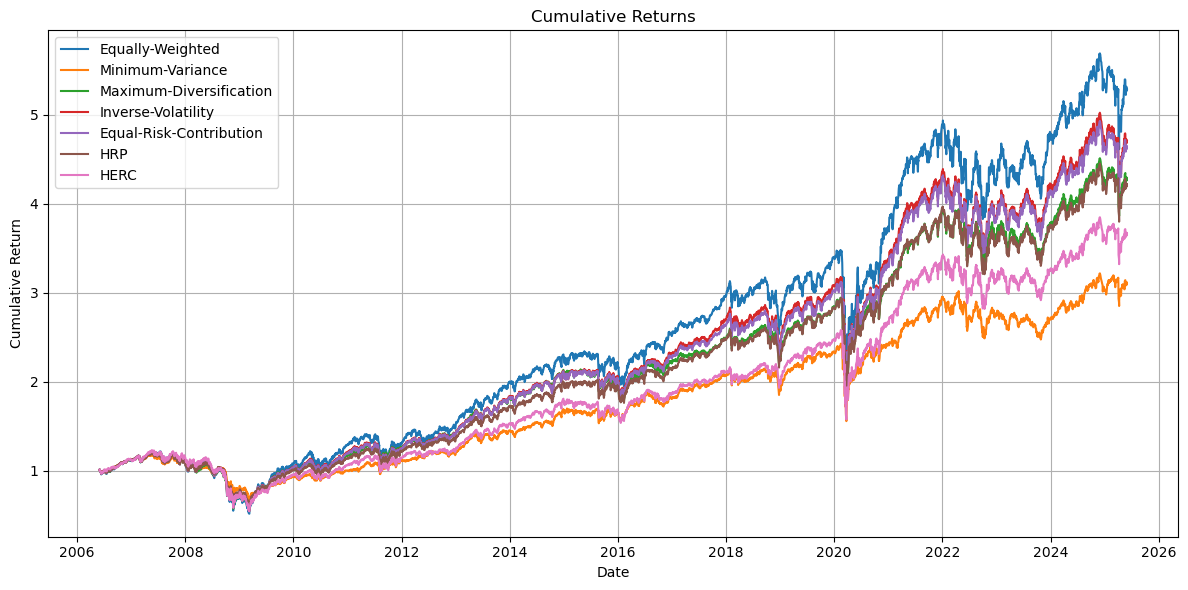

In [20]:
df_SP500["Date"] = pd.to_datetime(df_SP500["Date"])

#Date-Spalte als Index setzen
df_SP500 = df_SP500.set_index("Date")

#Kumulierte Rendite berechnen (angenommen tägliche Returns)
#(1 + r).cumprod() - 1 ergibt den Gesamtzuwachs in Prozent
kumulative_returns = gesamt_return(df_SP500)

#Plot
plt.figure(figsize=(12,6))
plt.plot(kumulative_returns)
plt.title("Cumulative Returns")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend(kumulative_returns.columns, loc="upper left")
plt.grid(True)
plt.tight_layout()
plt.show()

#### Sharpe Ratio

In [21]:
df_SP500.index = pd.to_datetime(df_SP500.index)
sharpe_jahresweise = df_SP500.groupby(df_SP500.index.year).apply(lambda x: x.apply(lambda y: sharpe_ratio(y) * np.sqrt(252)))

In [22]:
sharpe_jahresweise

,Equally-Weighted,Minimum-Variance,Maximum-Diversification,Inverse-Volatility,Equal-Risk-Contribution,HRP,HERC
Date,,,,,,,
2006,1.763736,2.719118,2.030136,2.012273,2.021659,2.227616,2.277672
2007,0.048422,-0.109193,-0.001435,0.014197,0.013726,-0.024071,0.230929
2008,-0.720285,-0.917729,-0.882775,-0.779253,-0.801000,-0.834321,-0.903538
2009,1.278346,0.918650,1.376629,1.256283,1.265930,1.242200,1.106201
2010,1.033331,0.696053,0.933908,0.968133,0.955567,0.891283,0.812490
2011,0.168777,0.862498,0.489886,0.260847,0.293896,0.447320,0.469571
2012,1.112332,0.732912,1.075517,1.080518,1.076521,1.029480,0.766487
2013,2.477924,2.102549,2.514862,2.413176,2.442406,2.395502,2.160563
2014,1.142296,1.518189,1.406375,1.195855,1.240218,1.299295,1.491677


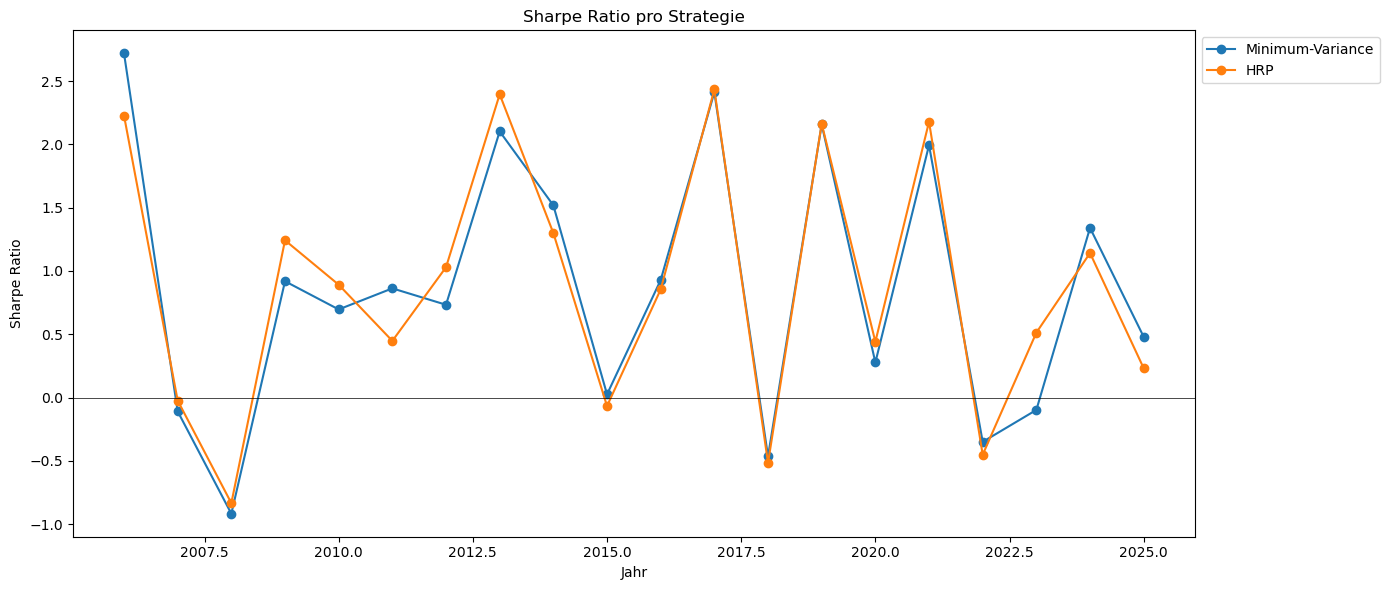

In [23]:
#Plotten der SR
strategien = sharpe_jahresweise.columns
years = sharpe_jahresweise.index

plt.figure(figsize=(14,6))

strategie = "Minimum-Variance"
plt.plot(years, sharpe_jahresweise[strategie], label=strategie, marker='o')

strategie = "HRP"
plt.plot(years, sharpe_jahresweise[strategie], label=strategie, marker='o')

plt.axhline(0, color='black', linewidth=0.5)  
plt.xlabel("Jahr")
plt.ylabel("Sharpe Ratio")
plt.title("Sharpe Ratio pro Strategie")
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.show()

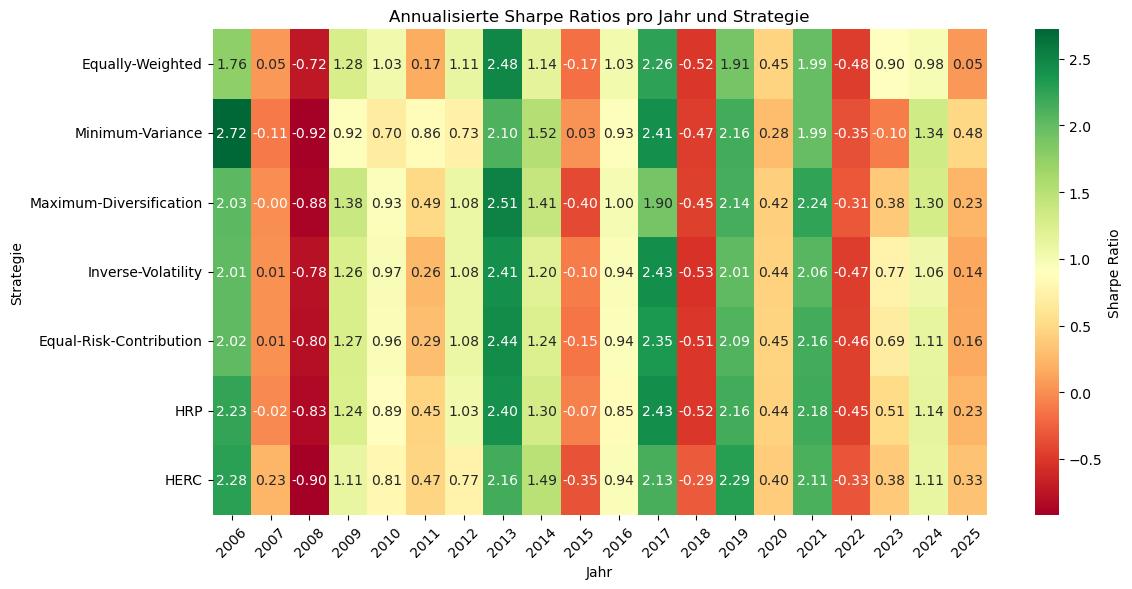

In [24]:
plt.figure(figsize=(12,6))
sb.heatmap(sharpe_jahresweise.T,        
            annot=True,                  
            fmt=".2f",                 
            cmap="RdYlGn",               
            cbar_kws={'label': 'Sharpe Ratio'})  

plt.title("Annualisierte Sharpe Ratios pro Jahr und Strategie")
plt.xlabel("Jahr")
plt.ylabel("Strategie")
plt.yticks(rotation=0) 
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [25]:
#Simulation mit synthetischen Werten

np.random.seed(42)

#Simulation: 20 Jahre, 252 Handelstage pro Jahr
years = 20
days_per_year = 252
mu_daily = 0.0005      
sigma_daily = 0.01     

#Simulierte tägliche Renditen (normalverteilt)
daily_returns = np.random.normal(loc=mu_daily, scale=sigma_daily, size=(days_per_year*years,))

#Datum-Index erstellen
dates = pd.date_range(start="2000-01-01", periods=days_per_year*years, freq='B')
df_sim = pd.DataFrame(daily_returns, index=dates, columns=['Strategy'])

#Funktion für annualisierten Sharpe Ratio
def sharpe_annual(returns_daily):
    return (returns_daily.mean() / returns_daily.std()) * np.sqrt(days_per_year)

#Sharpe Ratios pro Jahr berechnen
sharpe_by_year = df_sim.groupby(df_sim.index.year).apply(lambda x: x.apply(sharpe_annual))

print(sharpe_by_year)

      Strategy
2000  0.938821
2001  0.686188
2002  0.254476
2003  3.547887
2004  1.809797
2005  2.077011
2006  1.241718
2007  0.797057
2008  1.363644
2009  0.511714
2010  2.034882
2011 -0.234316
2012  0.727365
2013  1.306639
2014 -0.508489
2015  0.455300
2016 -1.627256
2017  1.034871
2018  0.593904
2019  2.021202


In [26]:
#Funktion für annualisierten Sharpe Ratio
def sharpe_total(returns_daily):
    mean_daily = returns_daily.mean()
    std_daily = returns_daily.std()
    return (mean_daily / std_daily) * np.sqrt(4780)  # 252 Handelstage

#Gesamt-Sharpe Ratio für jede Strategie über alle Jahre
gesamt_sharpe = df_SP500.apply(sharpe_total)

print(gesamt_sharpe)

Equally-Weighted           2.232836
Minimum-Variance           2.097492
Maximum-Diversification    2.238303
Inverse-Volatility         2.226395
Equal-Risk-Contribution    2.236552
HRP                        2.245120
HERC                       2.025253
dtype: float64


In [27]:
#Funktion für annualisierten Sharpe Ratio
def sharpe_annual(returns_daily):
    mean_daily = returns_daily.mean()
    std_daily = returns_daily.std()
    return (mean_daily / std_daily) * np.sqrt(252)  # 252 Handelstage

#Gesamt-Sharpe Ratio für jede Strategie über alle Jahre
annualized_sharpe = df_SP500.apply(sharpe_annual)

print(annualized_sharpe)

Equally-Weighted           0.512676
Minimum-Variance           0.481600
Maximum-Diversification    0.513931
Inverse-Volatility         0.511197
Equal-Risk-Contribution    0.513529
HRP                        0.515497
HERC                       0.465014
dtype: float64


#### Sortino

In [28]:
df_SP500.index = pd.to_datetime(df_SP500.index)
sortino_jahresweise = df_SP500.groupby(df_SP500.index.year).apply(lambda x: x.apply(lambda y: sortino_ratio(y) * np.sqrt(252)))

In [29]:
sortino_jahresweise

,Equally-Weighted,Minimum-Variance,Maximum-Diversification,Inverse-Volatility,Equal-Risk-Contribution,HRP,HERC
Date,,,,,,,
2006,2.835073,4.530943,3.257281,3.290411,3.297250,3.671574,3.741822
2007,0.064405,-0.143371,-0.001888,0.018823,0.018169,-0.031735,0.307876
2008,-0.995240,-1.284796,-1.210829,-1.077588,-1.106386,-1.156693,-1.241512
2009,1.920220,1.316031,2.039369,1.872470,1.885600,1.837666,1.621415
2010,1.501935,0.981543,1.326677,1.403755,1.382480,1.282069,1.161238
2011,0.230652,1.207460,0.669438,0.356731,0.402114,0.613146,0.642934
2012,1.671850,1.088521,1.596710,1.618709,1.610630,1.536847,1.123681
2013,3.721836,3.152699,3.775133,3.645405,3.687399,3.634711,3.268508
2014,1.595570,2.198348,2.016955,1.675148,1.742714,1.833636,2.163503


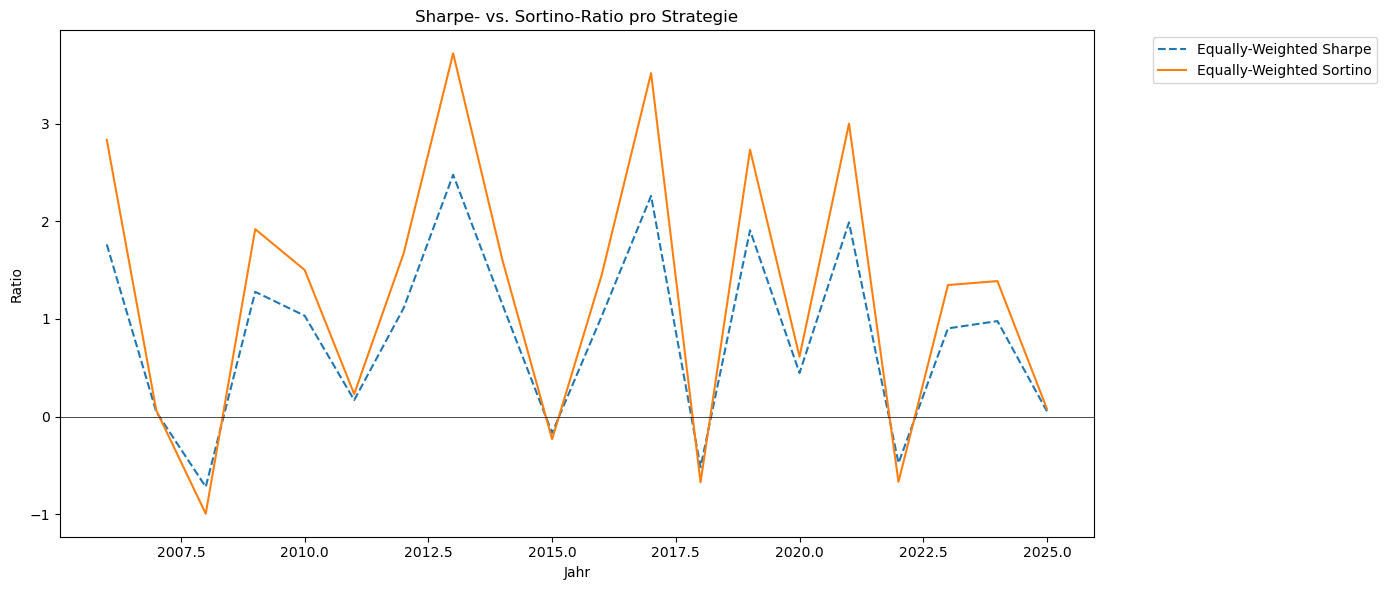

In [30]:
#Vergleich Sharpe und Sortino
strategies = sharpe_jahresweise.columns
jahre = sharpe_jahresweise.index

plt.figure(figsize=(14,6))

strategie = "Equally-Weighted"

plt.plot(jahre, sharpe_jahresweise[strategie], label=f"{strategie} Sharpe", linestyle='--')
plt.plot(jahre, sortino_jahresweise[strategie], label=f"{strategie} Sortino", linestyle='-')

plt.axhline(0, color='black', linewidth=0.5)
plt.xlabel("Jahr")
plt.ylabel("Ratio")
plt.title("Sharpe- vs. Sortino-Ratio pro Strategie")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [31]:
#Funktion für annualisierten Sharpe Ratio
def sortino_annual(returns_daily):
    zins_risikofrei = 0
    mean_daily = returns_daily.mean()
    temp = (np.minimum(0, returns_daily - zins_risikofrei))**2
    temp = np.mean(temp)
    downside_dev = np.sqrt(temp)
    return (mean_daily / downside_dev) * np.sqrt(252)  # 252 Handelstage

#Gesamt-Sortino Ratio für jede Strategie über alle Jahre
gesamt_sortino = df_SP500.apply(sortino_annual)

print(gesamt_sortino)

Equally-Weighted           0.723794
Minimum-Variance           0.669982
Maximum-Diversification    0.716705
Inverse-Volatility         0.718456
Equal-Risk-Contribution    0.721065
HRP                        0.721474
HERC                       0.648740
dtype: float64


#### Maximum Drawdown

In [32]:
df_SP500.index = pd.to_datetime(df_SP500.index)
max_drawdown_jahresweise = df_SP500.groupby(df_SP500.index.year).apply(lambda x: x.apply(maximum_drawdown))

In [33]:
max_drawdown_jahresweise

,Equally-Weighted,Minimum-Variance,Maximum-Diversification,Inverse-Volatility,Equal-Risk-Contribution,HRP,HERC
Date,,,,,,,
2006,-0.054790,-0.030562,-0.048796,-0.047054,-0.047396,-0.040779,-0.047311
2007,-0.123021,-0.096362,-0.112166,-0.117261,-0.116150,-0.110034,-0.110144
2008,-0.512739,-0.322577,-0.475862,-0.473962,-0.475443,-0.432429,-0.492966
2009,-0.323752,-0.194171,-0.284949,-0.288547,-0.287998,-0.257916,-0.283062
2010,-0.157931,-0.075637,-0.110075,-0.138420,-0.133487,-0.113020,-0.111602
2011,-0.220246,-0.122988,-0.152749,-0.190875,-0.184074,-0.159218,-0.157323
2012,-0.110624,-0.055946,-0.065449,-0.086050,-0.083714,-0.063952,-0.059032
2013,-0.067075,-0.073317,-0.067371,-0.066017,-0.065871,-0.065286,-0.067527
2014,-0.075192,-0.046734,-0.057074,-0.069268,-0.066547,-0.060193,-0.050869


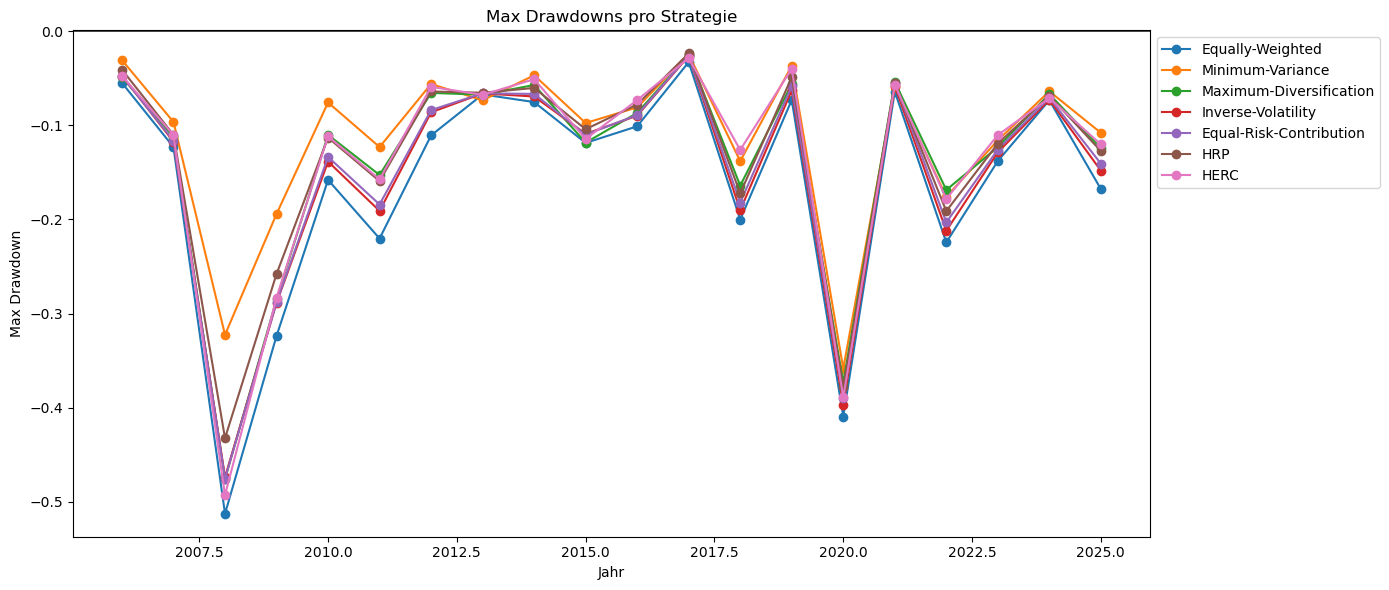

In [34]:
#Plotten der MDDs
strategien = max_drawdown_jahresweise.columns
years = max_drawdown_jahresweise.index

plt.figure(figsize=(14,6))

for strategie in strategies:
    plt.plot(years, max_drawdown_jahresweise[strategie], label=strategie, marker='o')

plt.axhline(0, color='black', linewidth=0.5)  # Null-Linie
plt.xlabel("Jahr")
plt.ylabel("Max Drawdown")
plt.title("Max Drawdowns pro Strategie")
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [35]:
df_SP500.index = pd.to_datetime(df_SP500.index)
max_drawdown_total = df_SP500.apply(maximum_drawdown)

max_drawdown_total.info

<bound method Series.info of Equally-Weighted          -0.576256
Minimum-Variance          -0.435459
Maximum-Diversification   -0.551362
Inverse-Volatility        -0.545203
Equal-Risk-Contribution   -0.546935
HRP                       -0.514035
HERC                      -0.558385
dtype: float64>

#### Calmar Ratio

In [36]:
df_SP500.index = pd.to_datetime(df_SP500.index)
calmar_jahresweise = df_SP500.groupby(df_SP500.index.year).apply(lambda x: x.apply(calmar_ratio_total))

In [37]:
calmar_jahresweise

,Equally-Weighted,Minimum-Variance,Maximum-Diversification,Inverse-Volatility,Equal-Risk-Contribution,HRP,HERC
Date,,,,,,,
2006,2.137684,4.162000,2.454372,2.598189,2.573093,3.038717,2.671722
2007,-0.050285,-0.229619,-0.098487,-0.092147,-0.090183,-0.135278,0.219733
2008,-0.682049,-0.809490,-0.723558,-0.699830,-0.704178,-0.719643,-0.740468
2009,1.482683,0.724882,1.451939,1.339916,1.346936,1.220003,1.037160
2010,1.289692,1.038608,1.252972,1.223644,1.215174,1.176062,1.067480
2011,0.046867,1.002630,0.523898,0.178613,0.226851,0.453346,0.481411
2012,1.389673,1.010399,1.742996,1.524667,1.533041,1.662115,1.256233
2013,5.017308,3.052497,4.380298,4.674335,4.666253,4.365415,3.739282
2014,1.783785,3.023773,2.660619,1.941978,2.075459,2.295673,3.007178


In [38]:
df_SP500.index = pd.to_datetime(df_SP500.index)
calmar_total = df_SP500.apply(calmar_ratio)

calmar_total.info

<bound method Series.info of Equally-Weighted           0.159300
Minimum-Variance           0.141774
Maximum-Diversification    0.144667
Inverse-Volatility         0.156127
Equal-Risk-Contribution    0.154140
HRP                        0.153470
HERC                       0.127157
dtype: float64>

In [39]:
df_SP500.index = pd.to_datetime(df_SP500.index)
calmar_total_2 = df_SP500.apply(calmar_ratio_total)

calmar_total_2.info

<bound method Series.info of Equally-Weighted           7.445304
Minimum-Variance           4.857547
Maximum-Diversification    5.962206
Inverse-Volatility         6.803578
Equal-Risk-Contribution    6.659952
HRP                        6.267901
HERC                       4.787812
dtype: float64>

#### Value at Risk

In [40]:
df_SP500.index = pd.to_datetime(df_SP500.index)
var_jahresweise = df_SP500.groupby(df_SP500.index.year).apply(lambda x: x.apply(value_at_risk_func))

var_jahresweise

,Equally-Weighted,Minimum-Variance,Maximum-Diversification,Inverse-Volatility,Equal-Risk-Contribution,HRP,HERC
Date,,,,,,,
2006,-0.010400,-0.006907,-0.009288,-0.009278,-0.009068,-0.008051,-0.008642
2007,-0.020742,-0.015332,-0.017960,-0.019898,-0.019530,-0.019020,-0.018769
2008,-0.047715,-0.030860,-0.040138,-0.042933,-0.042217,-0.039146,-0.044293
2009,-0.034556,-0.016434,-0.028273,-0.028372,-0.028349,-0.024085,-0.025375
2010,-0.019367,-0.012574,-0.014790,-0.017462,-0.016981,-0.015066,-0.015235
2011,-0.027757,-0.013594,-0.019819,-0.024149,-0.023696,-0.019954,-0.019047
2012,-0.013472,-0.008465,-0.011069,-0.011926,-0.011782,-0.010325,-0.010180
2013,-0.012518,-0.008705,-0.010535,-0.011296,-0.011014,-0.010379,-0.010174
2014,-0.012160,-0.009733,-0.011071,-0.011446,-0.011100,-0.010718,-0.010443


In [41]:
df_SP500.index = pd.to_datetime(df_SP500.index)
var_total = df_SP500.apply(value_at_risk_func)

var_total.info

<bound method Series.info of Equally-Weighted          -0.020012
Minimum-Variance          -0.012949
Maximum-Diversification   -0.016297
Inverse-Volatility        -0.018262
Equal-Risk-Contribution   -0.018013
HRP                       -0.016434
HERC                      -0.016273
dtype: float64>

In [42]:
monthly_returns = df_SP500.resample('M').apply(lambda x: (1 + x).prod() - 1)
monthly_var = monthly_returns.apply(value_at_risk_func)

monthly_var.info

<bound method Series.info of Equally-Weighted          -0.076535
Minimum-Variance          -0.051365
Maximum-Diversification   -0.058851
Inverse-Volatility        -0.069409
Equal-Risk-Contribution   -0.067152
HRP                       -0.060574
HERC                      -0.063006
dtype: float64>

#### Expected Shortfall

In [43]:
df_SP500.index = pd.to_datetime(df_SP500.index)
es_jahresweise = df_SP500.groupby(df_SP500.index.year).apply(lambda x: x.apply(expected_shortfall))

es_jahresweise

,Equally-Weighted,Minimum-Variance,Maximum-Diversification,Inverse-Volatility,Equal-Risk-Contribution,HRP,HERC
Date,,,,,,,
2006,-0.013601,-0.008975,-0.012289,-0.012072,-0.012094,-0.010976,-0.011520
2007,-0.026671,-0.020143,-0.023052,-0.025619,-0.025126,-0.023745,-0.024691
2008,-0.069432,-0.042547,-0.061034,-0.062683,-0.062356,-0.056048,-0.063944
2009,-0.049647,-0.022887,-0.040436,-0.041687,-0.041552,-0.034811,-0.038824
2010,-0.029106,-0.018009,-0.022468,-0.026251,-0.025568,-0.022840,-0.022898
2011,-0.038578,-0.021715,-0.029919,-0.035289,-0.034483,-0.030433,-0.029589
2012,-0.018576,-0.010092,-0.014216,-0.016498,-0.016213,-0.014016,-0.013375
2013,-0.016661,-0.013712,-0.014652,-0.015684,-0.015472,-0.014813,-0.014586
2014,-0.017631,-0.012980,-0.015195,-0.016774,-0.016455,-0.015564,-0.014104


In [44]:
df_SP500.index = pd.to_datetime(df_SP500.index)
es_total = df_SP500.apply(expected_shortfall)

es_total.info

<bound method Series.info of Equally-Weighted          -0.033458
Minimum-Variance          -0.021984
Maximum-Diversification   -0.027867
Inverse-Volatility        -0.030492
Equal-Risk-Contribution   -0.029922
HRP                       -0.027252
HERC                      -0.028143
dtype: float64>

In [45]:
monthly_returns = df_SP500.resample('M').apply(lambda x: (1 + x).prod() - 1)
monthly_es  = monthly_returns.apply(expected_shortfall)

monthly_es.info

<bound method Series.info of Equally-Weighted          -0.111504
Minimum-Variance          -0.081076
Maximum-Diversification   -0.097301
Inverse-Volatility        -0.102410
Equal-Risk-Contribution   -0.101044
HRP                       -0.093335
HERC                      -0.098780
dtype: float64>

In [46]:
yearly_returns = df_SP500.resample('Y').apply(lambda x: (1 + x).prod() - 1)
yearly_es  = yearly_returns.apply(expected_shortfall)

yearly_es.info

<bound method Series.info of Equally-Weighted          -0.349713
Minimum-Variance          -0.261123
Maximum-Diversification   -0.344314
Inverse-Volatility        -0.331692
Equal-Risk-Contribution   -0.334796
HRP                       -0.311194
HERC                      -0.365026
dtype: float64>

In [47]:
#Zusammenfassung der Metriken
Zusammenfassung = pd.concat([annualized_sharpe, gesamt_sortino, max_drawdown_total, calmar_total_2, monthly_var, monthly_es], axis=1)
Zusammenfassung.columns = ["Sharpe", "Sortino", "Max Drawdown", "Calmar", "Var", "ES"]
print(Zusammenfassung)

                           Sharpe   Sortino  Max Drawdown    Calmar       Var  \
Equally-Weighted         0.512676  0.723794     -0.576256  7.445304 -0.076535   
Minimum-Variance         0.481600  0.669982     -0.435459  4.857547 -0.051365   
Maximum-Diversification  0.513931  0.716705     -0.551362  5.962206 -0.058851   
Inverse-Volatility       0.511197  0.718456     -0.545203  6.803578 -0.069409   
Equal-Risk-Contribution  0.513529  0.721065     -0.546935  6.659952 -0.067152   
HRP                      0.515497  0.721474     -0.514035  6.267901 -0.060574   
HERC                     0.465014  0.648740     -0.558385  4.787812 -0.063006   

                               ES  
Equally-Weighted        -0.111504  
Minimum-Variance        -0.081076  
Maximum-Diversification -0.097301  
Inverse-Volatility      -0.102410  
Equal-Risk-Contribution -0.101044  
HRP                     -0.093335  
HERC                    -0.098780  


## S&P 500 mit Ledoit-Shrinkage

## 2-Jahre Trainingsfenster S&P500

In [48]:
#Bearbeitete SP500-Daten (Gesamtbestand, 2 Jahre)

df_SP500_2jahre = pd.read_csv(
    'sampled_renditenJSE_neu_final.csv',
    sep=',',
    encoding='utf-8',
    index_col=0,
    decimal = '.',
    low_memory=False,
    parse_dates=['Date'],
    dayfirst=True
)

In [49]:
df_SP500_2jahre.info

<bound method DataFrame.info of             Date  Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
0     2006-06-01          0.000100          0.002144                 0.000098   
1     2006-06-02          0.017225          0.008433                 0.008282   
2     2006-06-05          0.000442         -0.000320                -0.000057   
3     2006-06-06         -0.032549         -0.022367                -0.025209   
4     2006-06-07         -0.023766         -0.027305                -0.025732   
...          ...               ...               ...                      ...   
4905  2025-05-26          0.003414          0.002334                 0.002558   
4906  2025-05-27          0.000590          0.003831                 0.001332   
4907  2025-05-28          0.000243          0.001885                 0.002229   
4908  2025-05-29          0.009547          0.006550                 0.006369   
4909  2025-05-30          0.002974          0.004601                 0.003010

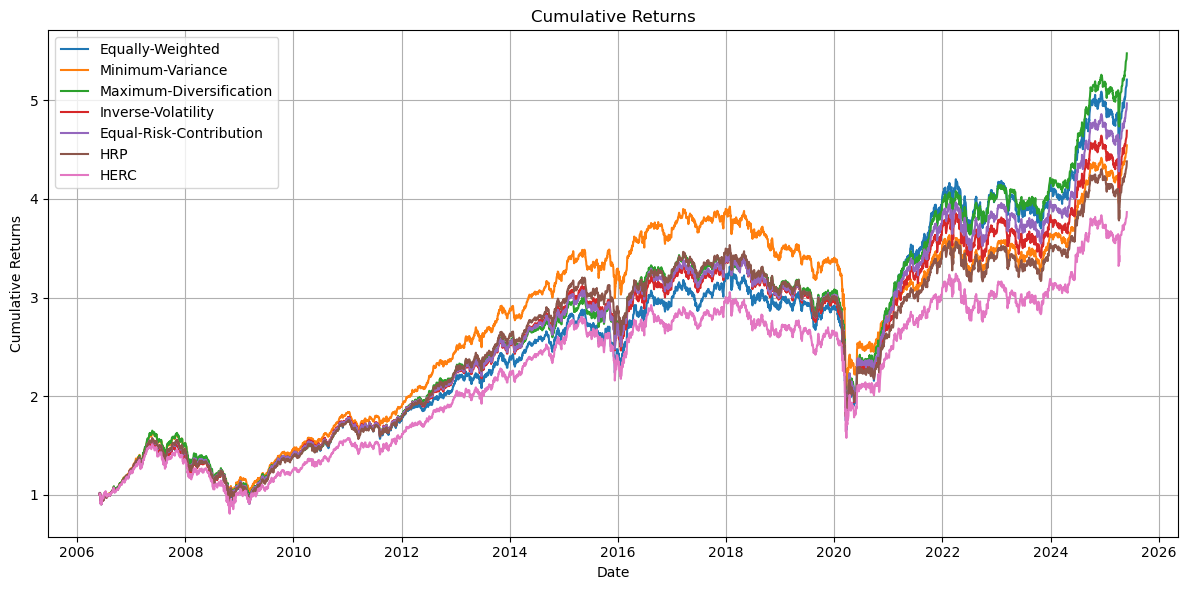

In [50]:
df_SP500_2jahre["Date"] = pd.to_datetime(df_SP500_2jahre["Date"])

#Date-Spalte als Index setzen
df_SP500_2jahre = df_SP500_2jahre.set_index("Date")

#Kumulierte Rendite berechnen (angenommen tägliche Returns)
#(1 + r).cumprod() - 1 ergibt den Gesamtzuwachs in Prozent
kumulative_returns = gesamt_return(df_SP500_2jahre)

#Plot
plt.figure(figsize=(12,6))
plt.plot(kumulative_returns)
plt.title("Cumulative Returns")
plt.xlabel("Date")
plt.ylabel("Cumulative Returns")
plt.legend(kumulative_returns.columns, loc="upper left")
plt.grid(True)
plt.tight_layout()
plt.show()

In [51]:
df_SP500_2jahre.index = pd.to_datetime(df_SP500_2jahre.index)
sharpe_jahresweise_2jahre = df_SP500_2jahre.groupby(df_SP500_2jahre.index.year).apply(lambda x: x.apply(lambda y: sharpe_ratio(y) * np.sqrt(252)))

sharpe_jahresweise_2jahre

,Equally-Weighted,Minimum-Variance,Maximum-Diversification,Inverse-Volatility,Equal-Risk-Contribution,HRP,HERC
Date,,,,,,,
2006,2.113431,2.839076,2.572401,2.224651,2.309847,2.508483,2.110262
2007,0.940499,1.633790,1.630500,0.949227,1.145804,1.222065,0.659172
2008,-0.908408,-1.286278,-1.395341,-0.909022,-1.029556,-1.189930,-0.920702
2009,1.620620,2.194736,2.024596,1.665198,1.756183,1.898612,1.328013
2010,1.850001,2.896191,2.634642,2.043990,2.201092,2.481420,2.141352
2011,0.034460,0.475869,0.284524,0.087191,0.131141,0.220369,0.179119
2012,2.537103,4.232025,3.643844,2.946116,3.201817,3.694001,2.773425
2013,0.967602,1.849960,1.353732,1.226522,1.294017,1.612904,0.967329
2014,1.281683,1.875533,1.466046,1.524081,1.497558,1.690596,1.557041


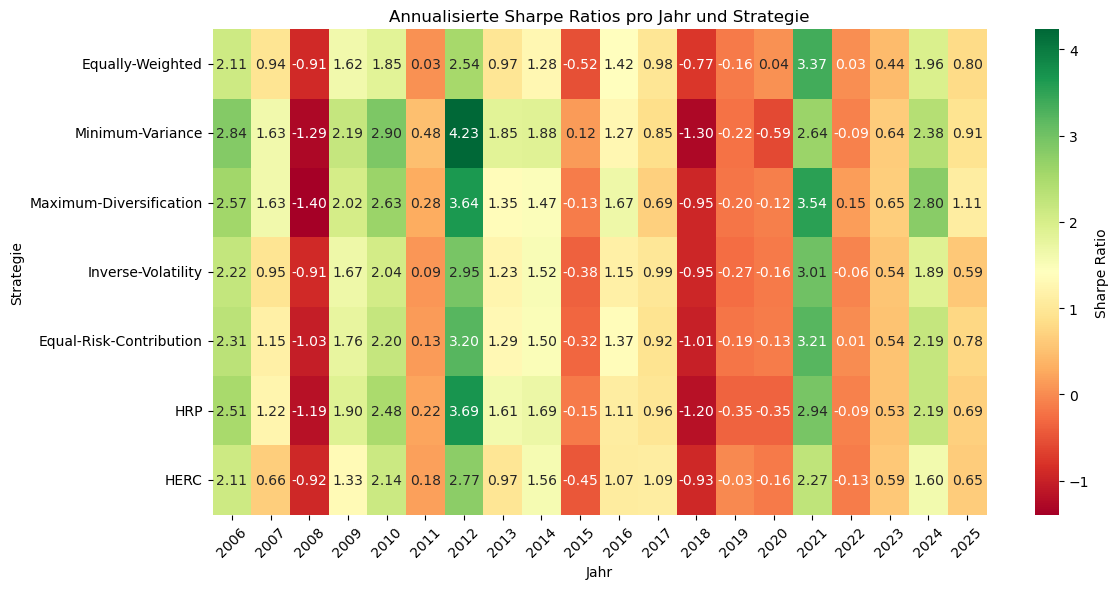

In [52]:
plt.figure(figsize=(12,6))
sb.heatmap(sharpe_jahresweise_2jahre.T,        
            annot=True,                  
            fmt=".2f",                   
            cmap="RdYlGn",               
            cbar_kws={'label': 'Sharpe Ratio'}) 

plt.title("Annualisierte Sharpe Ratios pro Jahr und Strategie")
plt.xlabel("Jahr")
plt.ylabel("Strategie")
plt.yticks(rotation=0) 
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

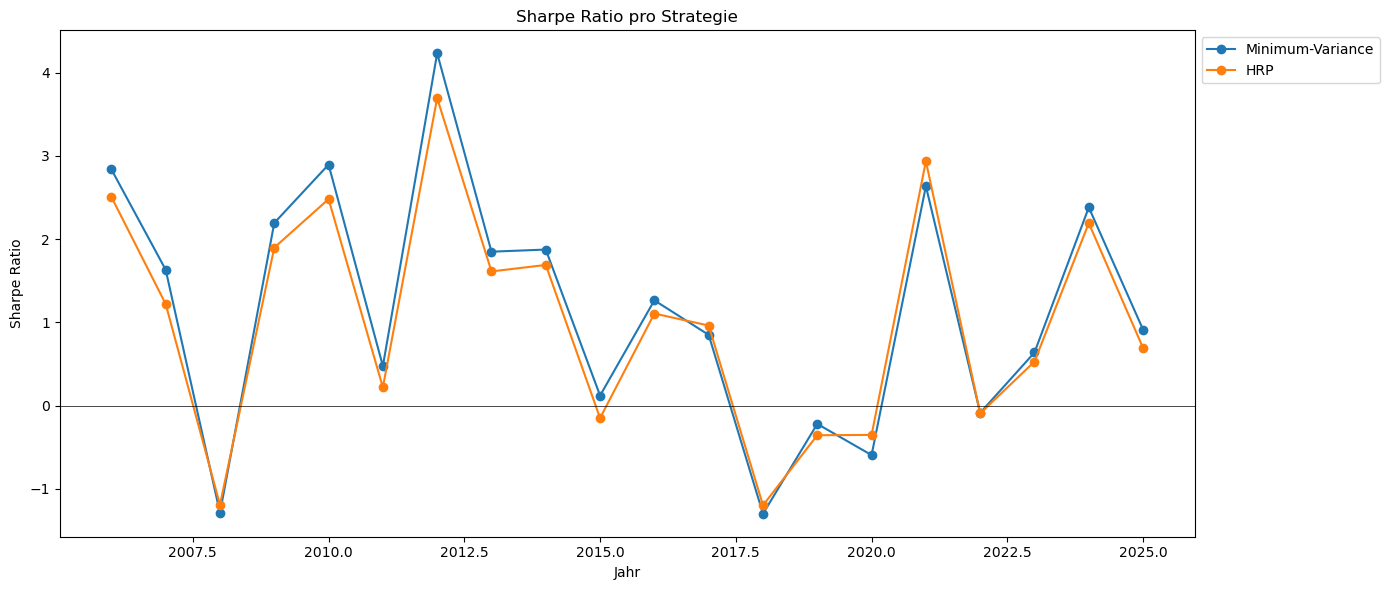

In [53]:
#Plotten der SR
strategien = sharpe_jahresweise_2jahre.columns
years = sharpe_jahresweise_2jahre.index

plt.figure(figsize=(14,6))

strategie = "Minimum-Variance"
plt.plot(years, sharpe_jahresweise_2jahre[strategie], label=strategie, marker='o')

strategie = "HRP"
plt.plot(years, sharpe_jahresweise_2jahre[strategie], label=strategie, marker='o')

plt.axhline(0, color='black', linewidth=0.5)  
plt.xlabel("Jahr")
plt.ylabel("Sharpe Ratio")
plt.title("Sharpe Ratio pro Strategie")
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [54]:
#Gesamt-Sharpe Ratio für jede Strategie über alle Jahre
def sharpe_total_2jahre(returns_daily):
    mean_daily = returns_daily.mean()
    std_daily = returns_daily.std()
    return (mean_daily / std_daily) * np.sqrt(4910)  # 252 Handelstage

gesamt_sharpe_2jahre = df_SP500_2jahre.apply(sharpe_total_2jahre)

print(gesamt_sharpe_2jahre)

Equally-Weighted           2.919820
Minimum-Variance           3.257798
Maximum-Diversification    3.526435
Inverse-Volatility         2.812122
Equal-Risk-Contribution    3.052988
HRP                        2.947495
HERC                       2.427339
dtype: float64


In [55]:
#Gesamt-Sharpe Ratio für jede Strategie über alle Jahre
def sharpe_annual_2jahre(returns_daily):
    mean_daily = returns_daily.mean()
    std_daily = returns_daily.std()
    return (mean_daily / std_daily) * np.sqrt(252)  # 252 Handelstage

annualized_sharpe_2jahre = df_SP500_2jahre.apply(sharpe_annual_2jahre)

print(annualized_sharpe_2jahre)

Equally-Weighted           0.661478
Minimum-Variance           0.738047
Maximum-Diversification    0.798905
Inverse-Volatility         0.637080
Equal-Risk-Contribution    0.691647
HRP                        0.667748
HERC                       0.549908
dtype: float64


In [56]:
df_SP500_2jahre.index = pd.to_datetime(df_SP500_2jahre.index)
sortino_jahresweise_2jahre = df_SP500_2jahre.groupby(df_SP500_2jahre.index.year).apply(lambda x: x.apply(lambda y: sortino_ratio(y) * np.sqrt(252)))

sortino_jahresweise_2jahre

,Equally-Weighted,Minimum-Variance,Maximum-Diversification,Inverse-Volatility,Equal-Risk-Contribution,HRP,HERC
Date,,,,,,,
2006,2.969472,4.045895,3.648849,3.120115,3.235553,3.511909,2.977742
2007,1.296364,2.255072,2.265772,1.308283,1.578918,1.680759,0.894639
2008,-1.216959,-1.687470,-1.801420,-1.222687,-1.369180,-1.562747,-1.242954
2009,2.419245,3.382355,3.070625,2.480644,2.629475,2.848877,1.989973
2010,2.746252,4.381290,3.933761,3.064322,3.289153,3.733652,3.246885
2011,0.046585,0.644198,0.384312,0.118084,0.177050,0.296198,0.248625
2012,3.877748,7.439006,6.079190,4.618923,5.120228,6.129800,4.299894
2013,1.315464,2.614027,1.860386,1.679623,1.773042,2.239024,1.325007
2014,1.903783,2.795811,2.132400,2.285474,2.221046,2.511710,2.387703


In [57]:
#Funktion für annualisierten Sharpe Ratio
def sortino_total_2jahre(returns_daily):
    zins_risikofrei = 0
    mean_daily = returns_daily.mean()
    temp = (np.minimum(0, returns_daily - zins_risikofrei))**2
    temp = np.mean(temp)
    downside_dev = np.sqrt(temp)
    return (mean_daily / downside_dev) * np.sqrt(4910)  # 252 Handelstage

#Gesamt-Sortino Ratio für jede Strategie über alle Jahre
gesamt_sortino_2jahre = df_SP500_2jahre.apply(sortino_total_2jahre)

print(gesamt_sortino_2jahre)

Equally-Weighted           4.049794
Minimum-Variance           4.389467
Maximum-Diversification    4.776925
Inverse-Volatility         3.881193
Equal-Risk-Contribution    4.187443
HRP                        3.996047
HERC                       3.363643
dtype: float64


In [58]:
#Funktion für annualisierten Sharpe Ratio
def sortino_annual_2jahre(returns_daily):
    zins_risikofrei = 0
    mean_daily = returns_daily.mean()
    temp = (np.minimum(0, returns_daily - zins_risikofrei))**2
    temp = np.mean(temp)
    downside_dev = np.sqrt(temp)
    return (mean_daily / downside_dev) * np.sqrt(252)  # 252 Handelstage

#Gesamt-Sortino Ratio für jede Strategie über alle Jahre
annualized_sortino_2jahre = df_SP500_2jahre.apply(sortino_annual_2jahre)

print(annualized_sortino_2jahre)

Equally-Weighted           0.917471
Minimum-Variance           0.994423
Maximum-Diversification    1.082201
Inverse-Volatility         0.879275
Equal-Risk-Contribution    0.948655
HRP                        0.905295
HERC                       0.762025
dtype: float64


In [59]:
df_SP500_2jahre.index = pd.to_datetime(df_SP500_2jahre.index)
max_drawdown_jahresweise_2jahre = df_SP500_2jahre.groupby(df_SP500_2jahre.index.year).apply(lambda x: x.apply(maximum_drawdown))

max_drawdown_jahresweise_2jahre

,Equally-Weighted,Minimum-Variance,Maximum-Diversification,Inverse-Volatility,Equal-Risk-Contribution,HRP,HERC
Date,,,,,,,
2006,-0.113327,-0.100100,-0.106085,-0.110030,-0.109040,-0.105902,-0.111208
2007,-0.159668,-0.139378,-0.152667,-0.152772,-0.153402,-0.144659,-0.164760
2008,-0.368677,-0.373676,-0.391591,-0.361744,-0.371457,-0.375668,-0.402604
2009,-0.195960,-0.131500,-0.136306,-0.194010,-0.177455,-0.173119,-0.144561
2010,-0.076506,-0.049695,-0.051230,-0.070362,-0.064433,-0.058981,-0.059737
2011,-0.120717,-0.100894,-0.098860,-0.111839,-0.107298,-0.107516,-0.105846
2012,-0.038977,-0.028225,-0.030225,-0.034423,-0.031312,-0.028202,-0.031934
2013,-0.074682,-0.074992,-0.064424,-0.074907,-0.071911,-0.076372,-0.079297
2014,-0.078386,-0.052859,-0.062685,-0.072632,-0.069674,-0.062260,-0.075127


In [60]:
df_SP500_2jahre.index = pd.to_datetime(df_SP500_2jahre.index)
max_drawdown_total_2jahre = df_SP500_2jahre.apply(maximum_drawdown)

max_drawdown_total_2jahre.info

<bound method Series.info of Equally-Weighted          -0.500625
Minimum-Variance          -0.492221
Maximum-Diversification   -0.482194
Inverse-Volatility        -0.513379
Equal-Risk-Contribution   -0.498622
HRP                       -0.514791
HERC                      -0.483970
dtype: float64>

In [61]:
df_SP500_2jahre.index = pd.to_datetime(df_SP500_2jahre.index)
calmar_jahresweise_2jahre = df_SP500_2jahre.groupby(df_SP500_2jahre.index.year).apply(lambda x: x.apply(calmar_ratio_total))

calmar_jahresweise_2jahre

,Equally-Weighted,Minimum-Variance,Maximum-Diversification,Inverse-Volatility,Equal-Risk-Contribution,HRP,HERC
Date,,,,,,,
2006,2.161933,2.634527,2.351721,2.270230,2.293935,2.440168,2.137655
2007,0.813789,1.444397,1.411983,0.832459,0.994840,1.076011,0.525636
2008,-0.620811,-0.646794,-0.693581,-0.613197,-0.633967,-0.667344,-0.586978
2009,1.574214,2.096931,2.076121,1.514601,1.624627,1.632424,1.547006
2010,3.128663,4.924397,4.653782,3.559303,3.792031,4.167950,4.111589
2011,-0.025928,0.351514,0.214556,0.031764,0.079015,0.153420,0.141961
2012,5.833240,10.433752,8.477018,7.333510,8.120427,9.594890,8.189337
2013,1.456809,2.324220,1.982159,1.852660,1.915810,2.181211,1.446011
2014,1.517237,2.545200,1.700177,1.948604,1.821784,2.186998,2.090622


In [62]:
df_SP500_2jahre.index = pd.to_datetime(df_SP500_2jahre.index)
calmar_total_2_2jahre = df_SP500_2jahre.apply(calmar_ratio_total)

calmar_total_2_2jahre.info

<bound method Series.info of Equally-Weighted           8.412186
Minimum-Variance           7.200602
Maximum-Diversification    9.285658
Inverse-Volatility         7.192978
Equal-Risk-Contribution    7.961906
HRP                        6.568436
HERC                       5.924236
dtype: float64>

In [63]:
df_SP500_2jahre.index = pd.to_datetime(df_SP500_2jahre.index)
var_jahresweise_2jahre = df_SP500_2jahre.groupby(df_SP500_2jahre.index.year).apply(lambda x: x.apply(value_at_risk_func))

var_jahresweise_2jahre

,Equally-Weighted,Minimum-Variance,Maximum-Diversification,Inverse-Volatility,Equal-Risk-Contribution,HRP,HERC
Date,,,,,,,
2006,-0.019949,-0.011954,-0.014788,-0.019876,-0.019051,-0.016860,-0.017089
2007,-0.015138,-0.013225,-0.013539,-0.014965,-0.014197,-0.014207,-0.015210
2008,-0.026642,-0.023397,-0.024827,-0.026136,-0.026069,-0.026168,-0.025768
2009,-0.018249,-0.011251,-0.012485,-0.016181,-0.015506,-0.014072,-0.016480
2010,-0.011955,-0.007099,-0.007505,-0.010832,-0.009953,-0.008630,-0.010232
2011,-0.012823,-0.008221,-0.008489,-0.012340,-0.011371,-0.009991,-0.013257
2012,-0.008003,-0.005164,-0.005824,-0.007970,-0.006941,-0.006122,-0.007566
2013,-0.012880,-0.009482,-0.010019,-0.012692,-0.012042,-0.010484,-0.013842
2014,-0.008656,-0.006033,-0.006878,-0.008332,-0.007322,-0.007278,-0.008723


In [64]:
df_SP500_2jahre.index = pd.to_datetime(df_SP500_2jahre.index)
var_total_2jahre = df_SP500_2jahre.apply(value_at_risk_func)

var_total_2jahre.info

<bound method Series.info of Equally-Weighted          -0.012962
Minimum-Variance          -0.009731
Maximum-Diversification   -0.010124
Inverse-Volatility        -0.012714
Equal-Risk-Contribution   -0.011955
HRP                       -0.011194
HERC                      -0.013513
dtype: float64>

In [65]:
monthly_returns_2jahre = df_SP500_2jahre.resample('M').apply(lambda x: (1 + x).prod() - 1)
monthly_var_2jahre = monthly_returns_2jahre.apply(value_at_risk_func)

monthly_var_2jahre.info

<bound method Series.info of Equally-Weighted          -0.044771
Minimum-Variance          -0.043016
Maximum-Diversification   -0.044714
Inverse-Volatility        -0.043979
Equal-Risk-Contribution   -0.042412
HRP                       -0.044724
HERC                      -0.053717
dtype: float64>

In [66]:
df_SP500_2jahre.index = pd.to_datetime(df_SP500_2jahre.index)
es_jahresweise_2jahre = df_SP500_2jahre.groupby(df_SP500_2jahre.index.year).apply(lambda x: x.apply(expected_shortfall))

es_jahresweise_2jahre

,Equally-Weighted,Minimum-Variance,Maximum-Diversification,Inverse-Volatility,Equal-Risk-Contribution,HRP,HERC
Date,,,,,,,
2006,-0.028915,-0.023527,-0.024482,-0.028317,-0.027342,-0.026382,-0.028300
2007,-0.021219,-0.018322,-0.019491,-0.020646,-0.020218,-0.019425,-0.022043
2008,-0.035498,-0.030507,-0.032408,-0.034475,-0.033619,-0.032834,-0.036254
2009,-0.022198,-0.013676,-0.015933,-0.020706,-0.018709,-0.017078,-0.019880
2010,-0.015850,-0.010493,-0.011117,-0.014737,-0.013473,-0.011872,-0.013598
2011,-0.017519,-0.011144,-0.012417,-0.016698,-0.015109,-0.013244,-0.017387
2012,-0.011011,-0.006959,-0.007500,-0.010096,-0.009104,-0.007841,-0.010794
2013,-0.017133,-0.012870,-0.013780,-0.016619,-0.015611,-0.014518,-0.017893
2014,-0.012284,-0.009067,-0.009728,-0.011930,-0.011103,-0.010416,-0.012590


In [67]:
df_SP500_2jahre.index = pd.to_datetime(df_SP500_2jahre.index)
es_total_2jahre = df_SP500_2jahre.apply(expected_shortfall)

es_total_2jahre.info

<bound method Series.info of Equally-Weighted          -0.021637
Minimum-Variance          -0.017143
Maximum-Diversification   -0.017938
Inverse-Volatility        -0.021040
Equal-Risk-Contribution   -0.019921
HRP                       -0.019086
HERC                      -0.021733
dtype: float64>

In [68]:
monthly_returns_2jahre = df_SP500_2jahre.resample('M').apply(lambda x: (1 + x).prod() - 1)
monthly_es_2jahre  = monthly_returns_2jahre.apply(expected_shortfall)

monthly_es_2jahre.info

<bound method Series.info of Equally-Weighted          -0.092775
Minimum-Variance          -0.088059
Maximum-Diversification   -0.089879
Inverse-Volatility        -0.091211
Equal-Risk-Contribution   -0.090447
HRP                       -0.091562
HERC                      -0.091031
dtype: float64>

In [69]:
yearly_returns_2jahre = df_SP500_2jahre.resample('Y').apply(lambda x: (1 + x).prod() - 1)
yearly_es_2jahre  = yearly_returns_2jahre.apply(expected_shortfall)

yearly_es_2jahre.info

<bound method Series.info of Equally-Weighted          -0.228878
Minimum-Variance          -0.241691
Maximum-Diversification   -0.271600
Inverse-Volatility        -0.221821
Equal-Risk-Contribution   -0.235492
HRP                       -0.250700
HERC                      -0.236320
dtype: float64>

In [70]:
#Zusammenfassung der Metriken
Zusammenfassung_2jahre = pd.concat([annualized_sharpe_2jahre, annualized_sortino_2jahre, max_drawdown_total_2jahre, calmar_total_2_2jahre, monthly_var_2jahre, monthly_es_2jahre], axis=1)
Zusammenfassung_2jahre.columns = ["Sharpe", "Sortino", "Max Drawdown", "Calmar", "Var", "ES"]
print(Zusammenfassung_2jahre)

                           Sharpe   Sortino  Max Drawdown    Calmar       Var  \
Equally-Weighted         0.661478  0.917471     -0.500625  8.412186 -0.044771   
Minimum-Variance         0.738047  0.994423     -0.492221  7.200602 -0.043016   
Maximum-Diversification  0.798905  1.082201     -0.482194  9.285658 -0.044714   
Inverse-Volatility       0.637080  0.879275     -0.513379  7.192978 -0.043979   
Equal-Risk-Contribution  0.691647  0.948655     -0.498622  7.961906 -0.042412   
HRP                      0.667748  0.905295     -0.514791  6.568436 -0.044724   
HERC                     0.549908  0.762025     -0.483970  5.924236 -0.053717   

                               ES  
Equally-Weighted        -0.092775  
Minimum-Variance        -0.088059  
Maximum-Diversification -0.089879  
Inverse-Volatility      -0.091211  
Equal-Risk-Contribution -0.090447  
HRP                     -0.091562  
HERC                    -0.091031  


## S&P 500 2Jahre Shrinked

## S&P500 3 Jahre

## S&P500 3 Jahre Shrinked

In [71]:
#Bearbeitete SP500-Daten (Gesamtbestand, 2 Jahre)

df_SP500_wharton = pd.read_csv(
    'sampled_Wharton_neu_final.csv',
    sep=',',
    encoding='utf-8',
    index_col=0,
    decimal = '.',
    low_memory=False,
    parse_dates=['Date'],
    dayfirst=True
)

In [72]:
df_SP500_wharton.info

<bound method DataFrame.info of             Date  Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
0     2006-06-01         -0.000670          0.000953                -0.000872   
1     2006-06-02          0.013546          0.008675                 0.007837   
2     2006-06-05         -0.001045         -0.001549                 0.000192   
3     2006-06-06         -0.022322         -0.014444                -0.015278   
4     2006-06-07         -0.020693         -0.012661                -0.014971   
...          ...               ...               ...                      ...   
4918  2025-05-26          0.005299          0.004087                 0.004664   
4919  2025-05-27          0.001126          0.001242                 0.000508   
4920  2025-05-28         -0.000122          0.001861                 0.001539   
4921  2025-05-29          0.007320          0.003269                 0.004264   
4922  2025-05-30          0.002160          0.004949                 0.002718

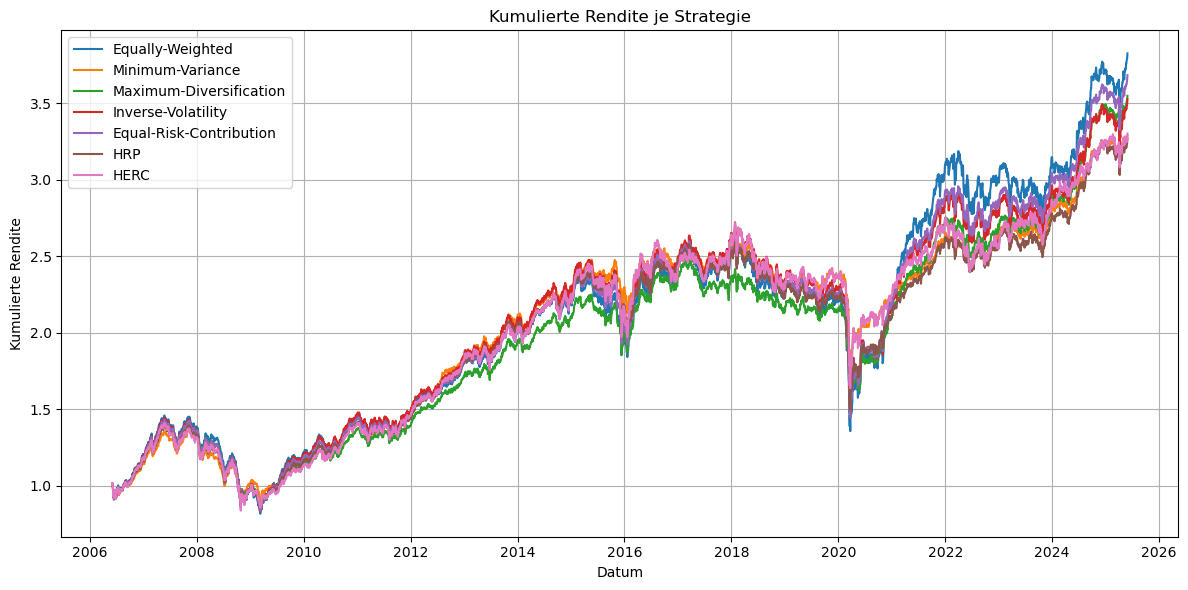

In [73]:
df_SP500_wharton["Date"] = pd.to_datetime(df_SP500_wharton["Date"])

#Date-Spalte als Index setzen
df_SP500_wharton = df_SP500_wharton.set_index("Date")

df_SP500_wharton.replace([np.inf, -np.inf], np.nan, inplace=True)
df_SP500_wharton = df_SP500_wharton.dropna()

#Kumulierte Rendite berechnen (angenommen tägliche Returns)
#(1 + r).cumprod() - 1 ergibt den Gesamtzuwachs in Prozent
kumulative_returns = gesamt_return(df_SP500_wharton)

#Plot
plt.figure(figsize=(12,6))
plt.plot(kumulative_returns)
plt.title("Kumulierte Rendite je Strategie")
plt.xlabel("Datum")
plt.ylabel("Kumulierte Rendite")
plt.legend(kumulative_returns.columns, loc="upper left")
plt.grid(True)
plt.tight_layout()
plt.show()

In [74]:
df_SP500_wharton.index = pd.to_datetime(df_SP500_wharton.index)
sharpe_jahresweise_wharton = df_SP500_wharton.groupby(df_SP500_wharton.index.year).apply(lambda x: x.apply(lambda y: sharpe_ratio(y) * np.sqrt(252)))

sharpe_jahresweise_wharton

,Equally-Weighted,Minimum-Variance,Maximum-Diversification,Inverse-Volatility,Equal-Risk-Contribution,HRP,HERC
Date,,,,,,,
2006,2.237986,2.390247,2.630673,2.271589,2.355079,2.344514,2.067886
2007,1.256770,1.677341,1.634848,1.244810,1.359509,1.462533,1.060664
2008,-1.553338,-1.660667,-1.851648,-1.517764,-1.619967,-1.685017,-1.359046
2009,1.618792,1.596551,1.468461,1.619703,1.625095,1.698247,1.301763
2010,1.709942,2.905203,2.432903,2.034901,2.194929,2.510120,2.368080
2011,0.119490,0.451171,0.259391,0.164629,0.182834,0.286437,0.385503
2012,2.747197,4.206037,3.550019,3.088674,3.306335,3.741210,2.914761
2013,1.176258,1.807338,1.667566,1.260856,1.409422,1.570506,1.034295
2014,1.094854,1.280536,1.248937,1.153474,1.157549,1.193787,1.098034


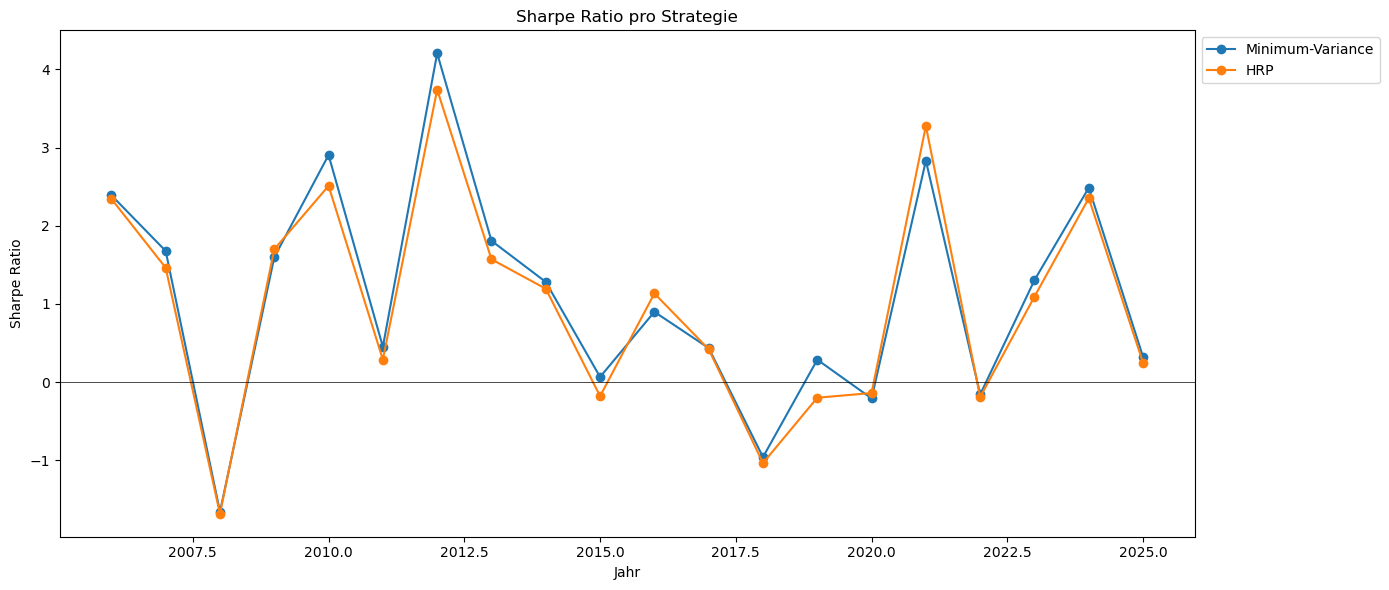

In [75]:
#Plotten der SR
strategien = sharpe_jahresweise_wharton.columns
years = sharpe_jahresweise_wharton.index

plt.figure(figsize=(14,6))

strategie = "Minimum-Variance"
plt.plot(years, sharpe_jahresweise_wharton[strategie], label=strategie, marker='o')

strategie = "HRP"
plt.plot(years, sharpe_jahresweise_wharton[strategie], label=strategie, marker='o')

plt.axhline(0, color='black', linewidth=0.5)  
plt.xlabel("Jahr")
plt.ylabel("Sharpe Ratio")
plt.title("Sharpe Ratio pro Strategie")
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [76]:
#Gesamt-Sharpe Ratio für jede Strategie über alle Jahre
def sharpe_annual_wharton(returns_daily):
    mean_daily = returns_daily.mean()
    std_daily = returns_daily.std()
    return (mean_daily / std_daily) * np.sqrt(252)  # 252 Handelstage

gesamt_sharpe_wharton = df_SP500_wharton.apply(sharpe_annual_wharton)

print(gesamt_sharpe_wharton)

Equally-Weighted           0.587586
Minimum-Variance           0.721190
Maximum-Diversification    0.709191
Inverse-Volatility         0.583270
Equal-Risk-Contribution    0.635890
HRP                        0.640545
HERC                       0.567402
dtype: float64


In [77]:
df_SP500_wharton.index = pd.to_datetime(df_SP500_wharton.index)
sortino_jahresweise_wharton = df_SP500_wharton.groupby(df_SP500_wharton.index.year).apply(lambda x: x.apply(lambda y: sortino_ratio(y) * np.sqrt(252)))

sortino_jahresweise_wharton

,Equally-Weighted,Minimum-Variance,Maximum-Diversification,Inverse-Volatility,Equal-Risk-Contribution,HRP,HERC
Date,,,,,,,
2006,2.973646,3.046596,3.389365,2.987445,3.075393,3.017070,2.719830
2007,1.721879,2.324390,2.236100,1.703522,1.853978,1.994887,1.443384
2008,-1.957801,-2.062140,-2.262439,-1.925071,-2.031946,-2.097556,-1.747810
2009,2.413563,2.445207,2.255187,2.403789,2.433715,2.539040,1.941601
2010,2.511869,4.434643,3.673025,3.029022,3.272807,3.772981,3.593663
2011,0.163494,0.622649,0.355974,0.225930,0.250376,0.393432,0.537741
2012,4.227875,7.481727,5.967453,4.850807,5.311477,6.270147,4.538725
2013,1.628232,2.570204,2.352588,1.748518,1.963386,2.203389,1.421939
2014,1.610004,1.841271,1.785789,1.702577,1.687377,1.727263,1.638965


In [78]:
#Funktion für annualisierten Sharpe Ratio
def sortino_annual_wharton(returns_daily):
    zins_risikofrei = 0
    mean_daily = returns_daily.mean()
    temp = (np.minimum(0, returns_daily - zins_risikofrei))**2
    temp = np.mean(temp)
    downside_dev = np.sqrt(temp)
    return (mean_daily / downside_dev) * np.sqrt(252)  # 252 Handelstage

#Gesamt-Sortino Ratio für jede Strategie über alle Jahre
annualized_sortino_wharton = df_SP500_wharton.apply(sortino_annual_wharton)

print(annualized_sortino_wharton)

Equally-Weighted           0.808878
Minimum-Variance           0.986287
Maximum-Diversification    0.965247
Inverse-Volatility         0.799706
Equal-Risk-Contribution    0.869860
HRP                        0.870097
HERC                       0.785517
dtype: float64


In [79]:
df_SP500_wharton.index = pd.to_datetime(df_SP500_wharton.index)
max_drawdown_jahresweise_wharton = df_SP500_wharton.groupby(df_SP500_wharton.index.year).apply(lambda x: x.apply(maximum_drawdown))

max_drawdown_jahresweise_wharton

,Equally-Weighted,Minimum-Variance,Maximum-Diversification,Inverse-Volatility,Equal-Risk-Contribution,HRP,HERC
Date,,,,,,,
2006,-0.103781,-0.094117,-0.083639,-0.100286,-0.095074,-0.094513,-0.101110
2007,-0.143979,-0.107919,-0.120150,-0.137225,-0.132427,-0.122728,-0.134192
2008,-0.376936,-0.327743,-0.360343,-0.365820,-0.363429,-0.351752,-0.363606
2009,-0.186308,-0.124964,-0.151039,-0.180776,-0.171892,-0.154910,-0.151016
2010,-0.091664,-0.049524,-0.060245,-0.072930,-0.066396,-0.060071,-0.062743
2011,-0.098168,-0.092219,-0.083850,-0.093335,-0.091196,-0.093066,-0.088963
2012,-0.036603,-0.018204,-0.020051,-0.034573,-0.029503,-0.025476,-0.032103
2013,-0.066558,-0.067424,-0.058285,-0.072979,-0.067957,-0.071241,-0.081090
2014,-0.072609,-0.054468,-0.057850,-0.071255,-0.066273,-0.062179,-0.077435


In [80]:
df_SP500_wharton.index = pd.to_datetime(df_SP500_wharton.index)
max_drawdown_total_wharton = df_SP500_wharton.apply(maximum_drawdown)

max_drawdown_total_wharton.info

<bound method Series.info of Equally-Weighted          -0.481999
Minimum-Variance          -0.354327
Maximum-Diversification   -0.412609
Inverse-Volatility        -0.468339
Equal-Risk-Contribution   -0.446153
HRP                       -0.422266
HERC                      -0.406962
dtype: float64>

In [81]:
df_SP500_wharton.index = pd.to_datetime(df_SP500_wharton.index)
calmar_jahresweise_wharton = df_SP500_wharton.groupby(df_SP500_wharton.index.year).apply(lambda x: x.apply(calmar_ratio_total))

calmar_jahresweise_wharton

,Equally-Weighted,Minimum-Variance,Maximum-Diversification,Inverse-Volatility,Equal-Risk-Contribution,HRP,HERC
Date,,,,,,,
2006,1.962064,1.572376,2.111455,1.956893,1.979306,1.774680,1.788546
2007,1.039240,1.354217,1.348525,1.006282,1.091060,1.159891,0.835144
2008,-0.775225,-0.684805,-0.762835,-0.746306,-0.753346,-0.739356,-0.695470
2009,1.316769,1.140202,1.026592,1.216712,1.183757,1.161959,1.035451
2010,2.146707,4.204358,3.261294,2.966720,3.156033,3.496066,3.775757
2011,0.074817,0.320666,0.202998,0.130317,0.142911,0.221116,0.428795
2012,6.185544,14.943790,11.439084,7.054758,8.092126,10.043250,7.870711
2013,1.827104,2.108798,2.274824,1.763400,1.938280,1.937922,1.359555
2014,1.312064,1.637877,1.479578,1.423238,1.382392,1.451030,1.346001


In [82]:
df_SP500_wharton.index = pd.to_datetime(df_SP500_wharton.index)
calmar_total_2_wharton = df_SP500_wharton.apply(calmar_ratio_total)

calmar_total_2_wharton.info

<bound method Series.info of Equally-Weighted           5.863233
Minimum-Variance           6.462263
Maximum-Diversification    6.175935
Inverse-Volatility         5.395887
Equal-Risk-Contribution    6.014365
HRP                        5.370218
HERC                       5.655461
dtype: float64>

In [83]:
df_SP500_wharton.index = pd.to_datetime(df_SP500_wharton.index)
var_jahresweise_wharton = df_SP500_wharton.groupby(df_SP500_wharton.index.year).apply(lambda x: x.apply(value_at_risk_func))

var_jahresweise_wharton

,Equally-Weighted,Minimum-Variance,Maximum-Diversification,Inverse-Volatility,Equal-Risk-Contribution,HRP,HERC
Date,,,,,,,
2006,-0.016863,-0.011205,-0.011435,-0.016604,-0.015117,-0.013541,-0.017017
2007,-0.011385,-0.008323,-0.009573,-0.011492,-0.010355,-0.010460,-0.011647
2008,-0.024001,-0.018928,-0.020490,-0.022521,-0.021884,-0.021290,-0.021776
2009,-0.015444,-0.008305,-0.010447,-0.013876,-0.013080,-0.010874,-0.012380
2010,-0.010262,-0.005505,-0.007046,-0.009240,-0.008134,-0.007031,-0.008229
2011,-0.011883,-0.007177,-0.007531,-0.011285,-0.010074,-0.008652,-0.011602
2012,-0.007002,-0.004827,-0.005343,-0.007063,-0.006225,-0.005711,-0.007815
2013,-0.011045,-0.006839,-0.007751,-0.010935,-0.009937,-0.008900,-0.011933
2014,-0.008448,-0.006618,-0.006473,-0.008533,-0.007254,-0.007545,-0.008670


In [84]:
df_SP500_wharton.index = pd.to_datetime(df_SP500_wharton.index)
var_total_wharton = df_SP500_wharton.apply(value_at_risk_func)

var_total_wharton.info

<bound method Series.info of Equally-Weighted          -0.012287
Minimum-Variance          -0.007822
Maximum-Diversification   -0.008827
Inverse-Volatility        -0.011572
Equal-Risk-Contribution   -0.010668
HRP                       -0.009375
HERC                      -0.011640
dtype: float64>

In [85]:
monthly_returns_wharton = df_SP500_wharton.resample('M').apply(lambda x: (1 + x).prod() - 1)
monthly_var_wharton = monthly_returns_wharton.apply(value_at_risk_func)

monthly_var_wharton.info

<bound method Series.info of Equally-Weighted          -0.046372
Minimum-Variance          -0.038622
Maximum-Diversification   -0.035791
Inverse-Volatility        -0.043624
Equal-Risk-Contribution   -0.041649
HRP                       -0.040093
HERC                      -0.043150
dtype: float64>

In [86]:
df_SP500_wharton.index = pd.to_datetime(df_SP500_wharton.index)
es_jahresweise_wharton = df_SP500_wharton.groupby(df_SP500_wharton.index.year).apply(lambda x: x.apply(expected_shortfall))

es_jahresweise_wharton

,Equally-Weighted,Minimum-Variance,Maximum-Diversification,Inverse-Volatility,Equal-Risk-Contribution,HRP,HERC
Date,,,,,,,
2006,-0.025317,-0.019326,-0.019848,-0.025016,-0.023413,-0.021862,-0.025534
2007,-0.018843,-0.013538,-0.015693,-0.017557,-0.016861,-0.015462,-0.017211
2008,-0.033625,-0.025029,-0.028715,-0.031798,-0.030612,-0.028569,-0.031636
2009,-0.018179,-0.010741,-0.012347,-0.016583,-0.015211,-0.013305,-0.014666
2010,-0.014462,-0.009633,-0.010559,-0.013039,-0.012000,-0.010862,-0.012154
2011,-0.015864,-0.009961,-0.010884,-0.014875,-0.013370,-0.011669,-0.015179
2012,-0.009948,-0.006409,-0.006884,-0.009267,-0.008289,-0.007430,-0.010226
2013,-0.014857,-0.010492,-0.010805,-0.014508,-0.013089,-0.012027,-0.015635
2014,-0.011901,-0.009873,-0.009750,-0.011810,-0.010995,-0.010641,-0.012701


In [87]:
monthly_returns_wharton = df_SP500_wharton.resample('M').apply(lambda x: (1 + x).prod() - 1)
monthly_es_wharton  = monthly_returns_wharton.apply(expected_shortfall)

monthly_es_wharton.info

<bound method Series.info of Equally-Weighted          -0.093762
Minimum-Variance          -0.072171
Maximum-Diversification   -0.080281
Inverse-Volatility        -0.088019
Equal-Risk-Contribution   -0.086134
HRP                       -0.080691
HERC                      -0.078044
dtype: float64>

In [88]:
#Zusammenfassung der Metriken
Zusammenfassung_wharton = pd.concat([gesamt_sharpe_wharton, annualized_sortino_wharton, max_drawdown_total_wharton, calmar_total_2_wharton, monthly_var_wharton, monthly_es_wharton], axis=1)
Zusammenfassung_wharton.columns = ["Sharpe", "Sortino", "Max Drawdown", "Calmar", "Var", "ES"]
print(Zusammenfassung_wharton)

                           Sharpe   Sortino  Max Drawdown    Calmar       Var  \
Equally-Weighted         0.587586  0.808878     -0.481999  5.863233 -0.046372   
Minimum-Variance         0.721190  0.986287     -0.354327  6.462263 -0.038622   
Maximum-Diversification  0.709191  0.965247     -0.412609  6.175935 -0.035791   
Inverse-Volatility       0.583270  0.799706     -0.468339  5.395887 -0.043624   
Equal-Risk-Contribution  0.635890  0.869860     -0.446153  6.014365 -0.041649   
HRP                      0.640545  0.870097     -0.422266  5.370218 -0.040093   
HERC                     0.567402  0.785517     -0.406962  5.655461 -0.043150   

                               ES  
Equally-Weighted        -0.093762  
Minimum-Variance        -0.072171  
Maximum-Diversification -0.080281  
Inverse-Volatility      -0.088019  
Equal-Risk-Contribution -0.086134  
HRP                     -0.080691  
HERC                    -0.078044  
